In [9]:
import urllib.request
import json
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock
from datetime import datetime


def fetch_naver_trend(client_id, client_secret, keywords, start_date, end_date, device="pc"):
    """
    네이버 데이터랩 검색 트렌드 API 호출 후 데이터프레임 반환
    - 날짜 인덱스, 키워드별 검색 비율 컬럼 포함

    Parameters:
    - client_id, client_secret: 네이버 API 인증키
    - keywords: 리스트, 예: ["상지건설"]
    - start_date, end_date: "YYYY-MM-DD"
    - device: "pc" or "mo" (default: "pc")

    Returns:
    - pandas DataFrame (날짜 인덱스)
    """
    url = "https://openapi.naver.com/v1/datalab/search"
    body = {
        "startDate": start_date,
        "endDate": end_date,
        "timeUnit": "date",
        "keywordGroups": [{"groupName": keywords[0], "keywords": keywords}],
        "device": device
    }

    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type", "application/json")

    try:
        response = urllib.request.urlopen(request, data=json.dumps(body).encode("utf-8"))
        if response.getcode() != 200:
            print(f"[Error] API 요청 실패: {response.getcode()}")
            return None
        data_json = json.loads(response.read().decode('utf-8'))
        data_list = data_json['results'][0]['data']

        df = pd.DataFrame(data_list)
        df['날짜'] = pd.to_datetime(df['period'])
        df.drop(columns='period', inplace=True)
        df.set_index('날짜', inplace=True)
        return df

    except Exception as e:
        print(f"[Exception] API 호출 실패: {e}")
        return None


def load_sentiment_summary(file_path):
    """
    로컬 CSV 파일에서 감성 요약 데이터 불러오기 (날짜 컬럼 datetime 변환)
    """
    df = pd.read_csv(file_path)
    df['날짜'] = pd.to_datetime(df['날짜'])
    return df


def get_daily_returns(ticker, start_date="2022-01-01", end_date=None, save_csv=True):
    """
    PyKRX를 통해 주가 일별 수익률 계산 및 CSV 저장
    
    Return = (전일 종가 / 당일 종가) - 1
    
    Returns:
    - DataFrame ['날짜', '종가', 'Return']
    """
    if end_date is None:
        end_date = datetime.today().strftime("%Y-%m-%d")

    df = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)
    df['Return'] = df['종가'].shift(1) / df['종가'] - 1
    df.reset_index(inplace=True)
    df = df[['날짜', '종가', 'Return']]

    if save_csv:
        filename = f"{ticker}_2days_later_return.csv"
        df.to_csv(filename, index=False)
        print(f"[✓] 주가 수익률 CSV 저장: {filename}")

    return df


def merge_dataframes_on_date(df1, df2):
    """
    두 데이터프레임을 '날짜' 컬럼 기준 inner join 병합
    - df2가 인덱스 날짜일 경우 reset_index 수행 및 컬럼명 보정 포함
    """
    df1['날짜'] = pd.to_datetime(df1['날짜'])

    df2 = df2.reset_index()
    if '날짜' not in df2.columns:
        df2.rename(columns={df2.columns[0]: '날짜'}, inplace=True)
    df2['날짜'] = pd.to_datetime(df2['날짜'])

    merged_df = pd.merge(df1, df2, on='날짜', how='inner')
    return merged_df


def add_weighted_score(df, ratio_col='ratio', sentiment_col='평균감성점수'):
    """
    가중 감성 점수 계산: ratio * 평균감성점수 컬럼 추가
    """
    df['weighted_score'] = df[ratio_col] * df[sentiment_col]
    return df


def lagged_correlation_weighted_score(df, return_col='Return', score_col='weighted_score', max_lag=7):
    """
    시차별 (0~max_lag) weighted_score와 Return 간 상관관계 분석 및 시각화
    
    Returns:
    - 상관계수 DataFrame
    - 최고 상관 정보 (row)
    """
    df = df.copy()
    results = []

    for lag in range(0, max_lag + 1):
        df[f'{return_col}_lag{lag}'] = df[return_col].shift(-lag)
        temp_df = df.dropna(subset=[f'{return_col}_lag{lag}', score_col])
        corr = temp_df[score_col].corr(temp_df[f'{return_col}_lag{lag}'])
        results.append({'Lag': lag, 'Correlation': corr})

    lag_df = pd.DataFrame(results)
    best_row = lag_df.loc[lag_df['Correlation'].abs().idxmax()]

    print("📊 시차별 상관계수:\n", lag_df)
    print(f"\n🎯 최고 상관: lag {best_row['Lag']}일, 상관계수 = {best_row['Correlation']:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(lag_df['Lag'], lag_df['Correlation'], marker='o', linestyle='-')
    plt.axvline(best_row['Lag'], color='red', linestyle='--', label=f"최고 상관 lag {int(best_row['Lag'])}")
    plt.title(f"'weighted_score' vs '{return_col}' 시차별 상관관계 (lag 0~{max_lag})")
    plt.xlabel("시차 (lag, 일)")
    plt.ylabel("상관계수")
    plt.legend()
    plt.grid(True)
    plt.show()

    return lag_df, best_row

📊 시차별 상관계수:
    Lag  Correlation
0    0     0.390423
1    1     0.150929
2    2     0.001356
3    3     0.078522
4    4     0.021601
5    5     0.015673
6    6     0.097254
7    7    -0.006957

🎯 최고 상관: lag 0.0일, 상관계수 = 0.3904


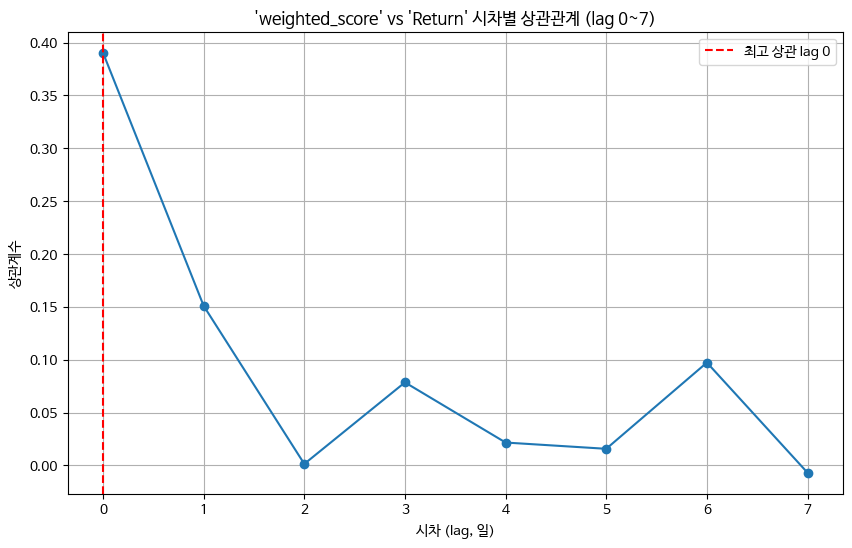

In [40]:
if __name__ == "__main__":
    # 네이버 API 정보
    client_id = "NjCkeE5n21b4IPWLlbAi"
    client_secret = "J6RWn6YJz8"
    keywords = ["제룡전기"]

    # 기간 설정
    start_date = "2024-06-23"
    end_date = "2025-06-23"

    # 1) 네이버 데이터랩 트렌드 불러오기
    trend_df = fetch_naver_trend(client_id, client_secret, keywords, start_date, end_date)
    if trend_df is None:
        print("트렌드 데이터 로드 실패, 종료")
        exit()

    # 2) 로컬 감성 요약 CSV 불러오기
    sentiment_path = 'daily_sentiment_summary_5.csv'
    sentiment_df = load_sentiment_summary(sentiment_path)

    # 3) 트렌드 데이터와 감성 요약 병합 (날짜 기준)
    merged_trend_sentiment = merge_dataframes_on_date(sentiment_df, trend_df)

    # 4) 가중 감성 점수 컬럼 추가
    merged_trend_sentiment = add_weighted_score(merged_trend_sentiment, ratio_col='ratio', sentiment_col='평균감성점수')

    # 5) 주가 수익률 불러오기 (PyKRX)
    ticker = "033100"
    returns_df = get_daily_returns(ticker, start_date=start_date, end_date=end_date, save_csv=False)

    # 6) 모든 데이터 날짜 기준 병합
    final_df = merge_dataframes_on_date(merged_trend_sentiment, returns_df)

    # 7) 시차별 상관관계 분석 및 시각화
    lag_df, best_lag = lagged_correlation_weighted_score(final_df, return_col='Return', score_col='weighted_score', max_lag=7)

In [39]:
final_df.head(3)

,날짜,평균감성점수,게시글수,평균신뢰도,감성분포,ratio,weighted_score,index,종가,Return
0,2025-03-05,-0.078,10,0.961,"{'중립': 9, '부정': 1}",10.46483,-0.816257,167,38400,-0.001302
1,2025-03-06,-0.073,13,0.950,"{'중립': 12, '부정': 1}",9.56437,-0.698199,168,37950,0.011858
2,2025-03-07,-0.091,38,0.944,"{'중립': 34, '부정': 4}",9.07763,-0.826064,169,36850,0.029851


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

def build_regression_with_interval(df, return_col='Return', score_col='weighted_score', lag=3):
    df = df.copy()

    # lag일 뒤 수익률 타겟 생성
    df[f'{return_col}_target'] = df[return_col].shift(-lag)

    # 결측 제거
    data = df.dropna(subset=[score_col, f'{return_col}_target'])
    X = data[[score_col]]
    y = data[f'{return_col}_target']

    # train/test 분리 (shuffle=False 시계열 유지)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 모델 학습 (랜덤포레스트 회귀)
    model = RandomForestRegressor(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)

    # 테스트 예측 및 성능 확인
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"테스트 MSE: {mse:.6f}")

    # 오차(잔차) 계산
    residuals = y_test - y_pred
    resid_std = np.std(residuals)

    return model, resid_std, lag

def predict_return_range(model, resid_std, weighted_score_value, lag, conf=1.96):
    """
    conf: 신뢰구간 z-score (1.96 = 약 95% 신뢰구간)
    """
    pred = model.predict([[weighted_score_value]])[0]
    lower = pred - conf * resid_std
    upper = pred + conf * resid_std

    print(f"{lag}일 후 예상 수익률: {pred:.4%}")
    print(f"예상 신뢰구간 (약 95%): {lower:.4%} ~ {upper:.4%}")
    return pred, lower, upper

In [37]:
model, resid_std, lag_used = build_regression_with_interval(final_df, return_col='Return', score_col='weighted_score', lag=5)

# 예측
pred, low, high = predict_return_range(model, resid_std, weighted_score_value=0.5, lag=lag_used)

테스트 MSE: 0.001203
5일 후 예상 수익률: -2.6747%
예상 신뢰구간 (약 95%): -8.9360% ~ 3.5866%


c:\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
